# dog_vs_cat
<a href="#jump" target="_self">1. 创建数据集</a>

<a href="#jump1" target="_self">2. 定义提取特征的模型</a>

## <span id = "jump"><font color="black">1. 创建数据集</font></span>

In [10]:
import os
import shutil
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
from torchvision.utils import save_image

use_cuda = torch.cuda.is_available()                    # gpu可用
device = torch.device('cuda' if use_cuda else 'cpu')    # 优先使用gpu

In [3]:
root_path = os.path.join('..', 'data', 'dog_vs_cat')     # 数据集的根目录     
source_path = os.path.join(root_path, 'kaggle_train')    # 原图像的目录
print('Data path:', root_path)

Data path: ..\data\dog_vs_cat


### 1.1 创建dog和cat的目录

In [4]:
def create_dir(class_name, phase):
    """
    class_name：类别名称，字符串
    phase：train或val
    """
    img_folder = os.path.join(root_path, phase, class_name)
    if not os.path.exists(img_folder):     
        os.mkdir(img_folder)           # 只能创建一个文件夹，无法创建嵌套的文件夹
        print(img_folder)
    
dir_list = [(i,j) for i in ['dog', 'cat'] for j in ['train', 'val']]  # 分为训练集和验证集
print(dir_list)
operation = list(map(lambda x: create_dir(*x), dir_list))             # 创建4个对应的目录

[('dog', 'train'), ('dog', 'val'), ('cat', 'train'), ('cat', 'val')]


### 1.2 将图像存放到对应路径

In [5]:
data_list = os.listdir(source_path)   # 列出原数据集中文件名，列表类型
print(data_list[:7])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg']


In [6]:
dog_list = list(filter(lambda x:x[:3]=='dog', data_list))     # 筛选出dog类型的文件 列表数据
print(dog_list[:7])
cat_list = list(filter(lambda x:x[:3]=='cat', data_list))     # 筛选cat类型文件 
print(cat_list[:7])

['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg', 'dog.10000.jpg', 'dog.10001.jpg']
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg']


In [7]:
def copy_data(root_path, file_list, target_class):
    """
    root_path：文件的根目录
    file_list：需要复制的文件的list
    target_class：需要复制的文件所属类别
    """
    for i in tqdm_notebook(range(len(file_list))):                  # tqdm为了显示进度条
        source_path = os.path.join(root_path, 'kaggle_train', file_list[i])
#         print(source_path)
        phase = 'train' if i < len(dog_list)*0.9 else 'val'         # 选取90%数据为训练，10%验证  
        target_path = os.path.join(root_path, phase, target_class, file_list[i])  # 创建目标目录
#         print(target_path)
        if not os.path.exists(target_path):         # 如果目标文件不存在
            shutil.copy(source_path, target_path)   # 复制文件到指定目录
copy_data(root_path, cat_list, 'cat')  
copy_data(root_path, dog_list, 'dog')

HBox(children=(IntProgress(value=0, max=12500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12500), HTML(value='')))

### 1.3 显示样本

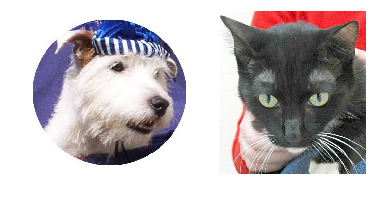

In [8]:
%matplotlib inline
dog_sample = np.random.choice(dog_list, size=1)    # 从列表汇总随机选取一个样本
cat_sample = np.random.choice(cat_list, size=1)
dog_img = plt.imread(os.path.join(root_path, 'kaggle_train', dog_sample[0]))# (191, 119, 3)
# print(dog_img.shape)
cat_img = plt.imread(os.path.join(root_path, 'kaggle_train', cat_sample[0]))
fig = plt.figure(figsize=(6,3))
fig.add_subplot(121)
plt.axis('off')
plt.imshow(dog_img)
fig.add_subplot(122)
plt.axis('off')
plt.imshow(cat_img)

## <span id = "jump1"><font color="black">2. 定义提取特征的模型</font></span>

In [24]:
# 定义模型来提取特征
class feature_net(nn.Module):
    def __init__(self, model):
        super().__init__()
        if model == 'inceptionv3':
            inception = models.inception_v3(pretrained=True)                # 使用预训练模型
            self.features = nn.Sequential(*list(inception.children())[:-1]) # 除去最后一层
            self.features._modules.pop('13')                                # 移除13层辅助分类层
            self.add_module('global average', nn.AvgPool2d(2,2))
    def forward(self, x):
        features = self.features(x)  # 提取特征
        return features


In [25]:
new_model = feature_net('inceptionv3')
test_in = torch.randn(1,3,224,224)
out = new_model(test_in)
print(out.shape)

torch.Size([1, 2048, 26, 26])


In [26]:
inception = models.inception_v3(pretrained=True)
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

)
